# Questions from Vicha
- Where should we get the histograms? The tutorial below is using Vicha's private dataset.
- Do we prepare a JSON file for the students or do we want them to extract it using Luka's profile?
- Do we have to plot the histograms in z-phi coordinates exactly as shown in DPS?
- Currently the workflow presented in this workbook is AE -> MSE -> PCA. Would we allow the students to explore the possibilities after MSE?

In this part of the tutorial, we will be using a pre-trained model to perform some inference and detect anomalies in the pixel occupancy plots. This pre-trained model is based on residual networks (see [K. He et al, arXiv:1512.03385](https://arxiv.org/abs/1512.03385) for more info) and is constructed in the form of autoencoders in the same way as in the previous part. Unlike the 1D autoencoder we saw earlier, this model is a 2D autoencoder that accepts 2D histograms.

# What we need
- Four model files in hdf5 format. Vicha already has it somewhere.
- ZeroBias rate for 2017B lumisections, obtained from OMS. We need this to normalise the histograms.

# Workflow in a nutshell
- Preprocess the histograms
    - Make sure that the histogram has the dimension of 200 x 140. We may have to trim it.
    - Normalise the histograms with a corresponding ZeroBias rate for each lumisection from OMS. **Do we prepare a JSON file for the students or do we want them to extract it using Luka's profile?**
- Run the model
    - Reconstruct all four histograms per each lumisection
    - Input: histogram of 200 x 140
    - Output: _reconstructed_ histogram of 200 x 140
- Interpret the reconstruction
    - For each histogram in a lumisection, calculate the difference using MSE, and calculate the mean of MSE from all pixels. We should have four numbers representing MSE loss for four histograms in each lumisection.
    - Perform PCA on a tuple of four numbers from all lumisections we have.

In [1]:
# Prerequisite packages
import pickle
import numpy as np
import keras
import tensorflow as tf
import uproot
import sklearn.preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

import mplhep as hep
plt.style.use([hep.style.CMS])
hep.rcParams.label.data = True
hep.rcParams.label.paper = True
hep.rcParams.label.llabel = "Preliminary"
hep.rcParams.label.lumi = None
hep.rcParams.label.year = 2017

2023-08-22 11:11:54.783028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6fa5c/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-c1d8e/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

# Preprocessing

In [23]:
# Obtain ZeroBias rate pre-obtained from OMS
datasetrate_df = pd.read_json("datasetrate_2017B.json")

# Load the models
models = [tf.keras.models.load_model(f"zphi{i}_resnet_v5/resnet_minsky_zphi{i}_0.50_best.hdf5", compile=False) for i in range(1, 5)]

# Obtain the histograms
# At this point the histograms will be obtained from Vicha's private collection
# TODO: Decide where we want student to get the histograms from
def gethist(fileloc, runnr, lumisection):
    rate_series = datasetrate_df[(datasetrate_df["run_number"] == runnr) & (datasetrate_df["first_lumisection_number"] == lumisection)]["rate"].to_list()
    if len(rate_series) != 1: raise Exception("Rate for this lumisection is not available!")
    rate = rate_series[0]
    
    zphi_temps = []
    for i in range(1, 5):
        #temphist = root_numpy.root2array("/eos/user/v/vwachira/Pixel2D/ZeroBias_2017B_DataFrame_2D_{}.root".format(fileloc), \
        #                                 "lumisections", f"hist_zphi{i}", f"runnr=={runnr} && lumisection=={lumisection}")
        
        temphist = uproot.open("/eos/user/v/vwachira/Pixel2D/ZeroBias_2017B_DataFrame_2D_{}.root".format(fileloc))["lumisections"]
        temphist = temphist.arrays([f"hist_zphi{i}"], f"(runnr=={runnr}) & (lumisection=={lumisection})")
        temphist = [obj[f"hist_zphi{i}"] for obj in temphist]
        temphist = np.reshape(temphist, (-1, 202, 302))
        temphist = np.reshape(temphist, (-1, 202, 302))[:, 1:201, 80:220]
        temphist = np.reshape(temphist, (-1, 200*140))
        temphist = temphist/rate
        temphist = np.reshape(temphist, (-1, 200, 140, 1))
        #temphist = temphist*(i+1)/2
        zphi_temps.append(temphist)
    return zphi_temps, rate

In [24]:
# The models are built using Keras, so you can see the structure of the network using summary method.
models[0].summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 140, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 200, 140, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 re_lu_1 (ReLU)                 (None, 200, 140, 16  0           ['conv2d_1[0][0]']               
                                )                                                           

In [25]:
sample_lumi = gethist(43, 297178, 568)

In [26]:
# The shape of one of the histograms
# We need the histograms to be in this shape since the model accepts inputs in (None, 200, 140, 1) shape.
sample_lumi[0][0].shape

(1, 200, 140, 1)

In [27]:
# ZeroBias rate of this lumisection
sample_lumi[1]

96.0515083322

In [28]:
# This model supports inputs that are normalised with ZeroBias rates,
# which we already did in the code above.
sample_input = [h for h in sample_lumi[0]]

In [29]:
sample_input[0].shape

(1, 200, 140, 1)

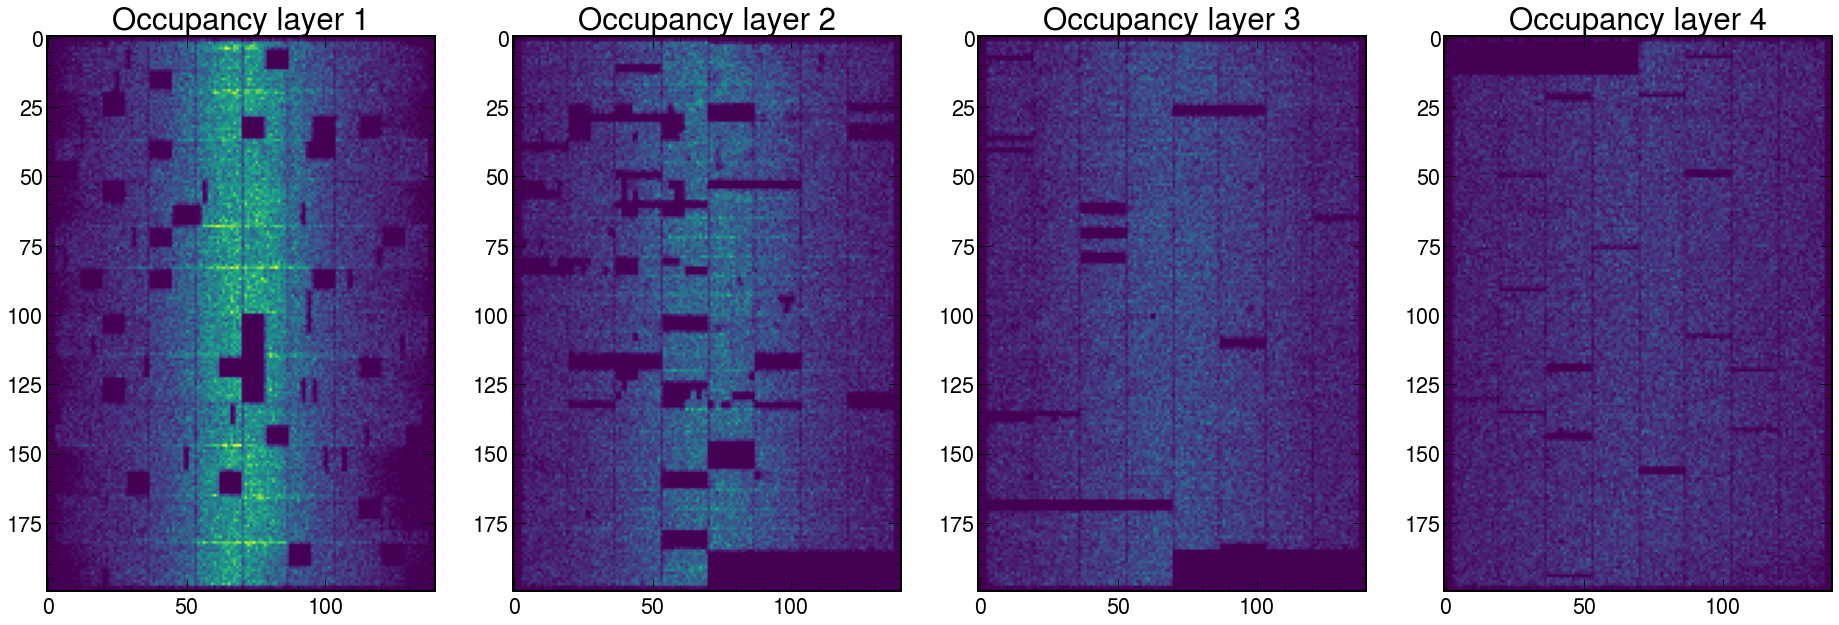

In [30]:
plt.figure(figsize=(32, 12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(sample_input[i].reshape((200, 140)), vmin=0, vmax=0.5)
    plt.title(f"Occupancy layer {i+1}")

# Inference

In [31]:
# Since we already have a model, inference should be pretty simple.
sample_output = [model.predict(h) for (h, model) in zip(sample_input, models)]

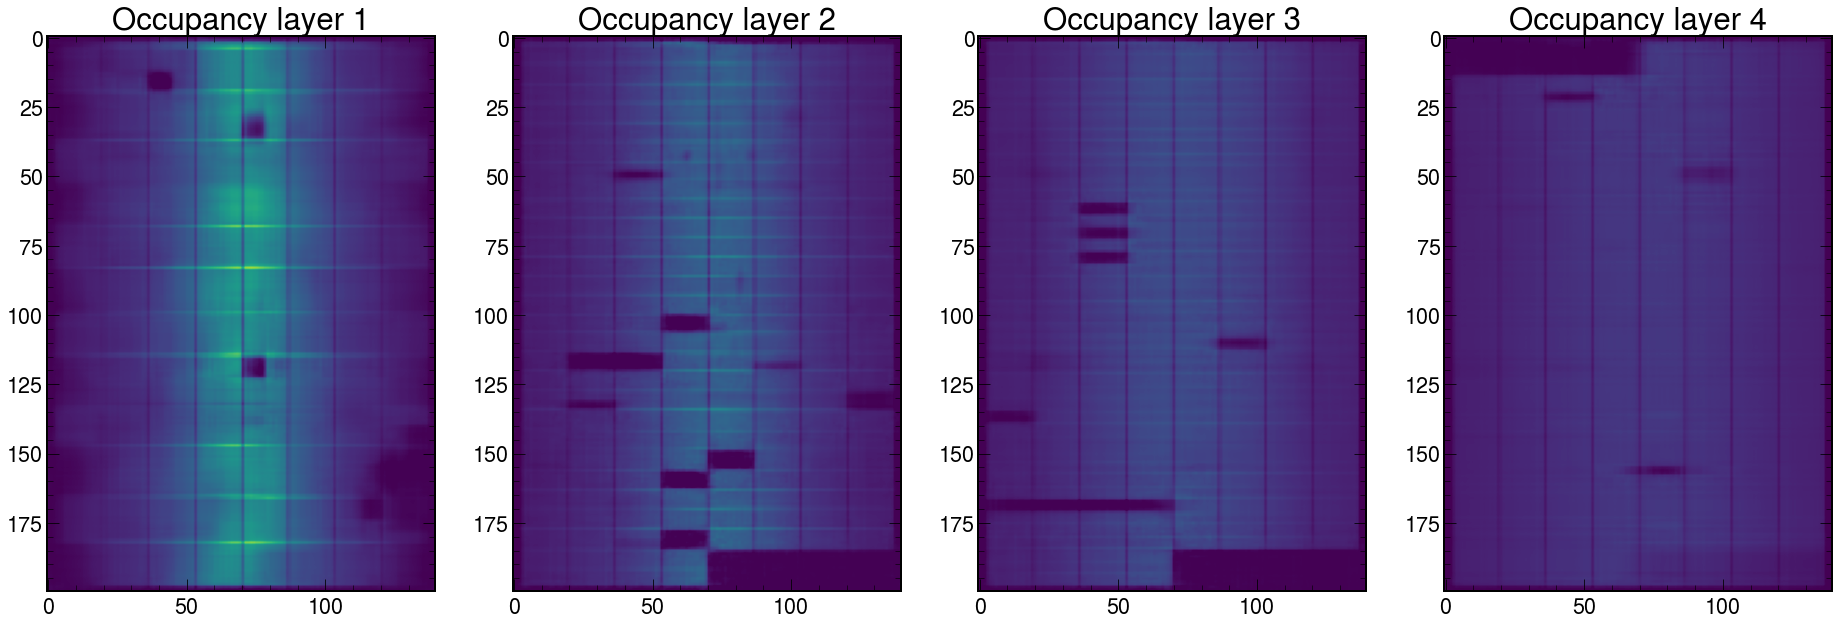

In [32]:
plt.figure(figsize=(32, 12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(sample_output[i].reshape((200, 140)), vmin=0, vmax=0.5)
    plt.title(f"Occupancy layer {i+1}")

In [35]:
differences = [np.array(keras.losses.mse(inputhist, outputhist)) for (inputhist, outputhist) in zip(sample_input, sample_output)]

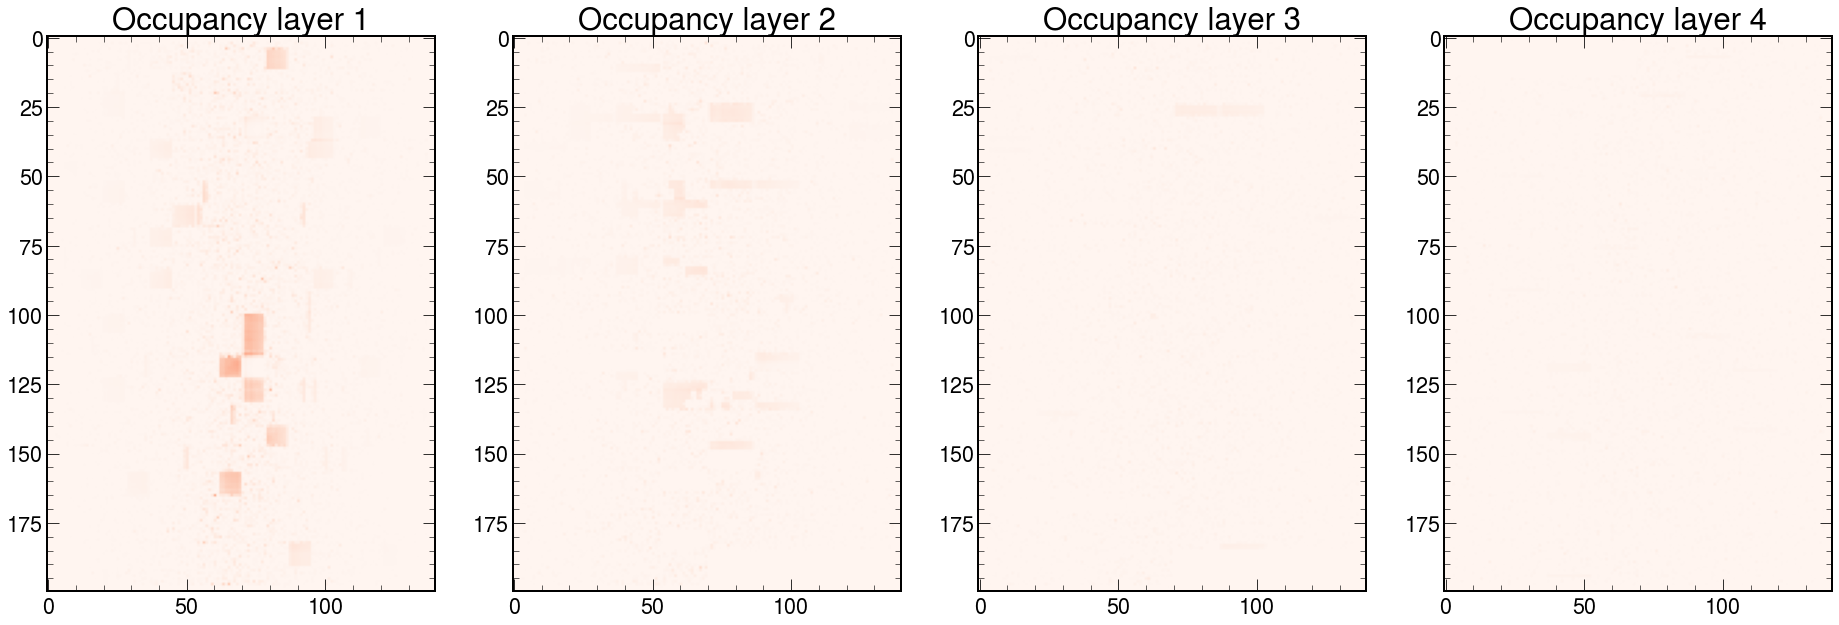

In [37]:
plt.figure(figsize=(32, 12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(differences[i].reshape((200, 140)), vmin=0, vmax=0.25, cmap="Reds")
    plt.title(f"Occupancy layer {i+1}")

In [41]:
# We can also calculate mean of 
[np.mean(d) for d in differences]

[0.0024313177, 0.0014418708, 0.00078518485, 0.0006254859]

With these reconstructions and differences, we can use them to summarise the reconstruction and see the error for any lumisection.

In [ ]:
def plot_zphi_set(fileloc, runnr, lumisection):
    FONTSIZE=15
    inputhists, rate = gethist(fileloc, runnr, lumisection)
    mainfig = plt.figure(figsize=(20, 17), facecolor="white")
    #fig, axes = plt.subplots(nrows=3, ncols=4)
    #fig.tight_layout()
    plt.subplots_adjust(left=0.1, bottom=None, right=0.9, top=None, wspace=None, hspace=None)
    for i in range(4):
        outputhist = models[i].predict(inputhists[i])
        difference = keras.losses.mse(inputhists[i], outputhist)
        
        outputhist = np.reshape(outputhist, (200, 140))
        difference = np.reshape(difference, (200, 140))
        
        ax = plt.subplot(3, 4, i+1)
        if i == 0: leftbound, _, mainfig_width, _ = plt.gca().get_position().bounds
        plot_truth = ax.imshow(inputhists[i].reshape(200, 140), vmin=0, vmax=0.5)
        plt.title(f"Barrel layer {i+1} original", fontsize=FONTSIZE)
        cbar = plt.colorbar(plot_truth)
        cbar.ax.set_ylabel("Normalised occupancy", fontsize=FONTSIZE)
        cbar.ax.tick_params(labelsize=FONTSIZE) 
        plt.tick_params(labelsize=FONTSIZE)
        plt.xticks(ticks=[70 + 140/56*i for i in range(-20, 21, 10)], labels=range(-20, 21, 10))
        plt.yticks(ticks=[100+100/3.2*i for i in np.arange(-3, 4, 1)], labels=range(-3, 4))
        plt.xlabel("Global z (cm)", fontsize=FONTSIZE)
        plt.ylabel("Global $\phi$", fontsize=FONTSIZE)
        #hep.cms.label(fontsize=FONTSIZE, loc=4)
        plt.gca().invert_yaxis()
        
        ax_pred = plt.subplot(3, 4, i+5)
        plot_pred = ax_pred.imshow(outputhist, vmin=0, vmax=0.5)
        cbar_reconstructed = plt.colorbar(plot_pred)
        cbar_reconstructed.ax.set_ylabel("Normalised occupancy", fontsize=FONTSIZE)
        cbar_reconstructed.ax.tick_params(labelsize=FONTSIZE) 
        plt.tick_params(labelsize=FONTSIZE)
        plt.xticks(ticks=[70 + 140/56*i for i in range(-20, 21, 10)], labels=range(-20, 21, 10))
        plt.yticks(ticks=[100+100/3.2*i for i in np.arange(-3, 4, 1)], labels=range(-3, 4))
        plt.title(f"Reconstructed", fontsize=FONTSIZE)
        plt.xlabel("Global z (cm)", fontsize=FONTSIZE)
        plt.ylabel("Global $\phi$", fontsize=FONTSIZE)
        #hep.cms.label(fontsize=FONTSIZE, loc=4)
        plt.gca().invert_yaxis()
        
        ax_mse = plt.subplot(3, 4, i+9)
        if i == 3: rightmost_leftbound, _, mainfig_width, _ = plt.gca().get_position().bounds
        plot_mse = ax_mse.imshow(difference, vmin=0, vmax=0.25, cmap="Reds")
        cbar_mse = plt.colorbar(plot_mse)
        cbar_mse.ax.set_ylabel("Mean squared error", fontsize=FONTSIZE)
        cbar_mse.ax.tick_params(labelsize=FONTSIZE) 
        plt.tick_params(labelsize=FONTSIZE)
        plt.xticks(ticks=[70 + 140/56*i for i in range(-20, 21, 10)], labels=range(-20, 21, 10))
        plt.yticks(ticks=[100+100/3.2*i for i in np.arange(-3, 4, 1)], labels=range(-3, 4))
        plt.title(f"MSE", fontsize=FONTSIZE)
        plt.xlabel("Global z (cm)", fontsize=FONTSIZE)
        plt.ylabel("Global $\phi$", fontsize=FONTSIZE)
        #plt.title(f"MSE: {MSE_mean:.6f}/{MSE_max:.6f}/{MSE_std:.6f}")
        #plt.colorbar()
        #hep.cms.label(fontsize=FONTSIZE, loc=0)
        plt.gca().invert_yaxis()
        
    cms_text = mainfig.text(leftbound, 0.92, "CMS", fontsize=FONTSIZE*1.3, fontweight='bold', horizontalalignment="left")
    mainfig.canvas.draw()
    #print(mainfig.get_size_inches())
    exp_offset = cms_text.get_window_extent().width/mainfig.dpi/mainfig.get_size_inches()[0]*1.05
    #print(exp_offset)
    mainfig.text(leftbound + exp_offset, 0.92, f"Run {runnr}, Lumisection {lumisection}", fontsize=FONTSIZE, style="italic", horizontalalignment="left")
    mainfig.text(rightmost_leftbound + mainfig_width, 0.92, "2017 (13 TeV)", fontsize=FONTSIZE, horizontalalignment="right")
    #plt.suptitle(f"Run {runnr}, Lumisection {lumisection}")
    #resnet_predict_and_compare(6, 297100, 229)

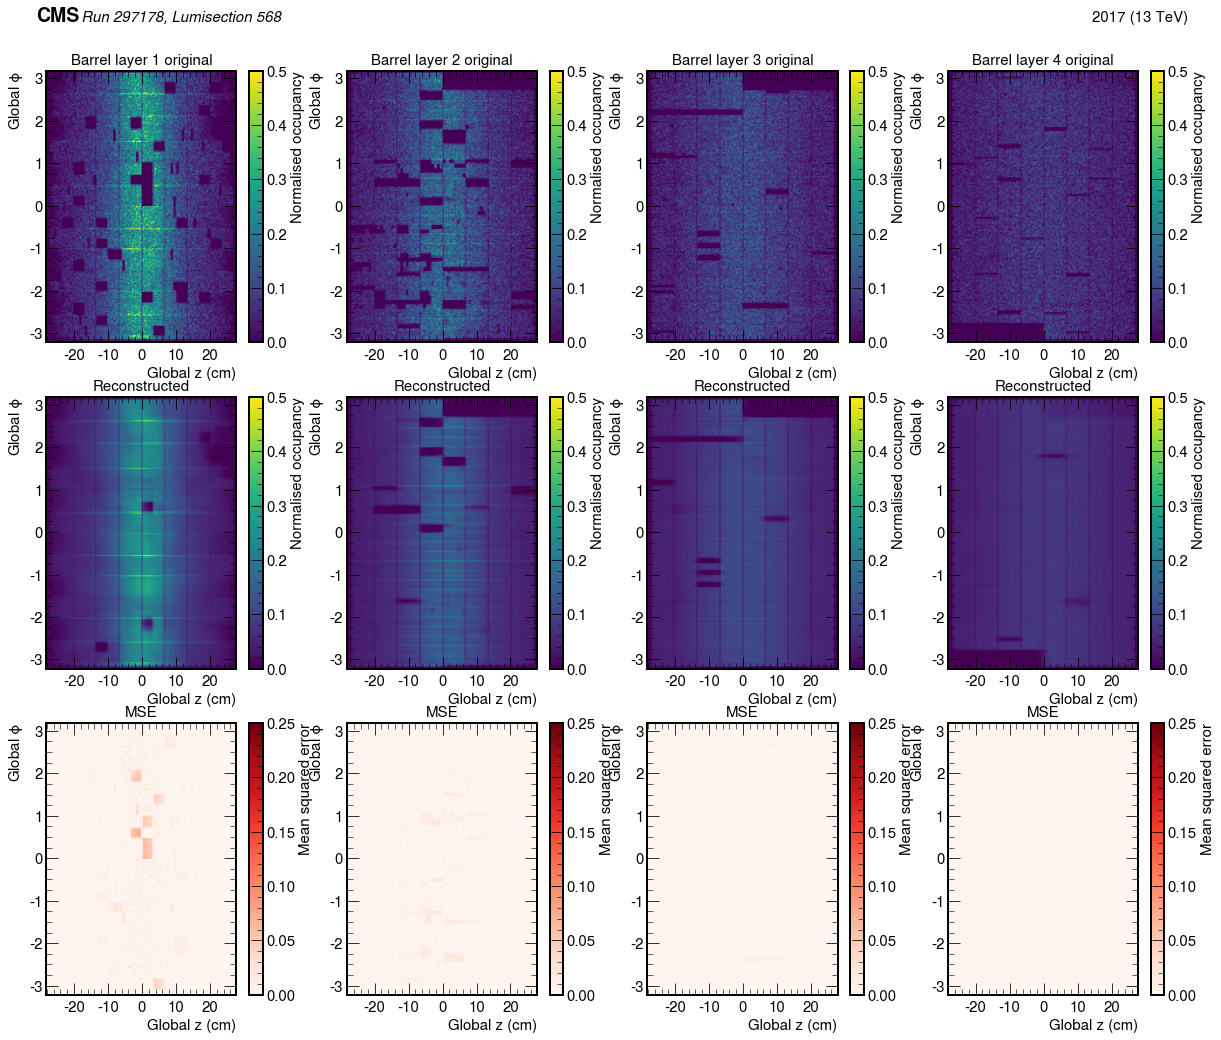

In [5]:
plot_zphi_set(43, 297178, 568)

# Inference on several lumisections

In [38]:
coordinates = uproot.open("/eos/user/v/vwachira/Pixel2D/ZeroBias_2017B_DataFrame_2D_12.root")["lumisections"]\
.arrays(["runnr", "lumisection"], library="np", how=list)
coordinates = np.array(coordinates).transpose()
coordinates = np.hstack(([[12]]*len(coordinates), coordinates))

In [40]:
coordinates

array([[    12, 297178,   1147],
       [    12, 297178,   1148],
       [    12, 297178,   1149],
       ...,
       [    12, 297057,    374],
       [    12, 297057,    375],
       [    12, 297057,    376]])

In [43]:
differences_list = []
for filenum, run, lumi in coordinates:
    try: # Needed since some lumisections do not have ZeroBias rate.
        inputhists, _ = gethist(filenum, run, lumi)
        reconstructed = [model.predict(h) for (h, model) in zip(inputhists, models)]
        differences = [np.array(keras.losses.mse(inputhist, outputhist)) for (inputhist, outputhist) in zip(inputhists, reconstructed)]
        differences_list.append([np.mean(d) for d in differences])
    except Exception:
        continue

In [44]:
differences_list

[[0.0019913125, 0.0010571108, 0.0006150011, 0.00049191026],
 [0.0019807706, 0.0010432708, 0.00061514514, 0.00048697696],
 [0.00198687, 0.0010517085, 0.00059821224, 0.00047132178],
 [0.0019884626, 0.0010518088, 0.0006123876, 0.0004901256],
 [0.0019555113, 0.0010239712, 0.00060049887, 0.00047908947],
 [0.0019344019, 0.0010194369, 0.000597193, 0.00047112157],
 [0.0017962785, 0.00096094515, 0.00057022035, 0.0004512392],
 [0.0017748044, 0.00096499705, 0.00057437783, 0.00045538894],
 [0.0018797672, 0.0010161777, 0.00059118815, 0.00047169017],
 [0.0018103756, 0.0009949926, 0.00058260054, 0.00045351434],
 [0.0018314626, 0.0009784544, 0.000580278, 0.00046136387],
 [0.0023231653, 0.0014317017, 0.0009822667, 0.00078625703],
 [0.4942029, 0.45331684, 0.3525203, 0.3169961],
 [0.0031311351, 0.0020341265, 0.0014886797, 0.0012071372],
 [0.0019547313, 0.0010141168, 0.0006086429, 0.00046978766],
 [0.0013503414, 0.0011033406, 0.0008029933, 0.0006493691],
 [0.0013517813, 0.0011521715, 0.00077856623, 0.0006

In [51]:
len(differences_list)

604

We can quickly perform PCA on this list of a tuple containing mean MSE.

In [45]:
from sklearn.decomposition import PCA
pca_MSEmean_obj = PCA(n_components=2)
pca_MSEmean_obj.fit(differences_list)

PCA(n_components=2)

In [48]:
pca_MSEmean_obj.transform(differences_list)

array([[-0.00320809, -0.00102014],
       [-0.00322391, -0.00102222],
       [-0.00322889, -0.00100835],
       ...,
       [ 0.00155278,  0.00252234],
       [ 0.00147477,  0.00236416],
       [ 0.00135824,  0.00242413]])

(-0.01, 0.01)

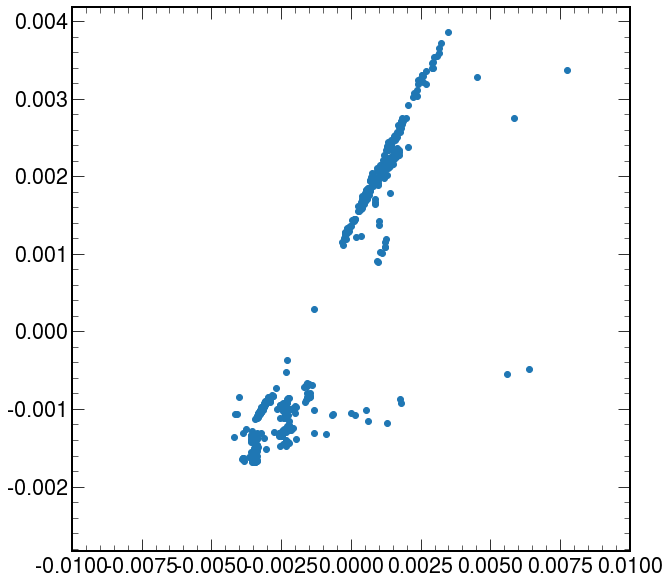

In [50]:
plt.scatter(*(pca_MSEmean_obj.transform(differences_list)).transpose())
plt.xlim(-0.01, 0.01)